In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

In [2]:
from torchvision import datasets, transforms

In [3]:
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=False)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=False)

In [4]:
print("Number of MNIST training examples: {}".format(len(mnist_train)))
print("Number of MNIST test examples: {}".format(len(mnist_test)))

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000


Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


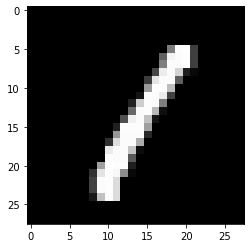

In [5]:
# Pick out the 4th (0-indexed) example from the training set
image, label = mnist_train[3]

# Plot the image
print("Default image shape: {}".format(image.shape))
image = image.reshape([28,28])
print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap="gray")

# Print the label
print("The label for this image: {}".format(label))

In [6]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [36]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


In [8]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


In [9]:
# Randomly initialize weights W
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

In [10]:
# Linear transformation with W and b
y = torch.matmul(x, W) + b

In [11]:
print(y[0,:])

tensor([ 0.6085,  0.0762,  0.0014,  0.0654,  0.1440,  0.4455,  0.6144, -0.0481,
         0.3546, -0.2253], grad_fn=<SliceBackward>)


In [12]:
# Option 1: Softmax to probabilities from equation
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

# Option 2: Softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py[0]))

py[0] from equation: tensor([0.1444, 0.0848, 0.0787, 0.0839, 0.0907, 0.1227, 0.1452, 0.0749, 0.1120,
        0.0627], grad_fn=<SelectBackward>)
py[0] with torch.nn.functional.softmax: tensor([0.1444, 0.0848, 0.0787, 0.0839, 0.0907, 0.1227, 0.1452, 0.0749, 0.1120,
        0.0627], grad_fn=<SelectBackward>)


In [13]:
print(labels.shape)

torch.Size([100])


In [14]:
# Cross-entropy loss from equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]),labels])
print("cross entropy from equation: {}".format(cross_entropy_eq))

# Option 2: cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy from equation: 2.264896869659424
cross entropy with torch.nn.functional.cross_entropy: 2.264897108078003


In [15]:
# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

In [16]:
cross_entropy.backward()

In [17]:
b.grad

tensor([-0.0053, -0.0194, -0.0018, -0.0075,  0.0320,  0.0313,  0.0264, -0.0362,
        -0.0123, -0.0071])

In [18]:
optimizer.step()

In [19]:
b

tensor([ 0.0005,  0.0019,  0.0002,  0.0008, -0.0032, -0.0031, -0.0026,  0.0036,
         0.0012,  0.0007], requires_grad=True)

In [20]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([-0.0053, -0.0194, -0.0018, -0.0075,  0.0320,  0.0313,  0.0264, -0.0362,
        -0.0123, -0.0071])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [21]:
# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]

In [22]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9038000106811523


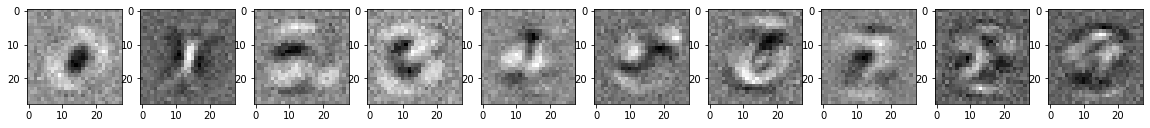

In [23]:
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

In [37]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Initialize parameters
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9036999940872192
